# Introduction to Parametric Linear Classifiers - Practice

**Authored by Alexandre Mathias DONNAT, Sr**

This notebook follows the subject:

- Perceptron (linear model with hard boundary)  
- Logistic regression (probabilistic model)  
- Evaluation methods: train / test, accuracy, precision, recall, F1  
- ROC curve, AUC, threshold influence  
- Comparative study on a real dataset (breast_cancer)

We note:

- $X \in \mathbb{R}^{n \times d}$ : data (n observations, d features)  
- $y \in \{-1, +1\}$ : labels for the perceptron  
- $y \in \{0,1\}$ : labels for logistic regression


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

## Exercise 1 – Data Generation

We generate 2D data with `make_blobs` for **two values** of the standard deviation:

- `cluster_std = 0.8` → well-separated classes (almost linearly separable)
- `cluster_std = 3.5` → heavily overlapping classes (not linearly separable)

For each `cluster_std`:

We generate 1000 points, 2 classes. We replace labels 0 with −1 for the perceptron. We split into train / test (70% / 30%). We store everything in a `datasets` dictionary.


In [ ]:
std_list = [0.8, 3.5]   
datasets = {}

for sigma in std_list:
    # generation
    X, y_01 = make_blobs(
        n_samples=1000,
        centers=2,
        n_features=2,
        cluster_std=sigma,
        random_state=42
    )
    y_pm1 = np.where(y_01 == 0, -1, 1)
    
    # split train / test
    X_train, X_test, y_train_01, y_test_01 = train_test_split(
        X, y_01,
        test_size=0.3,
        random_state=42,
        stratify=y_01
    )
    y_train_pm1 = np.where(y_train_01 == 0, -1, 1)
    y_test_pm1 = np.where(y_test_01 == 0, -1, 1)
    
    datasets[sigma] = dict(
        X=X, y_01=y_01, y_pm1=y_pm1,
        X_train=X_train, X_test=X_test,
        y_train_01=y_train_01, y_test_01=y_test_01,
        y_train_pm1=y_train_pm1, y_test_pm1=y_test_pm1
    )

{sigma: (d["X_train"].shape, d["X_test"].shape) for sigma, d in datasets.items()}

{0.8: ((700, 2), (300, 2)), 3.5: ((700, 2), (300, 2))}

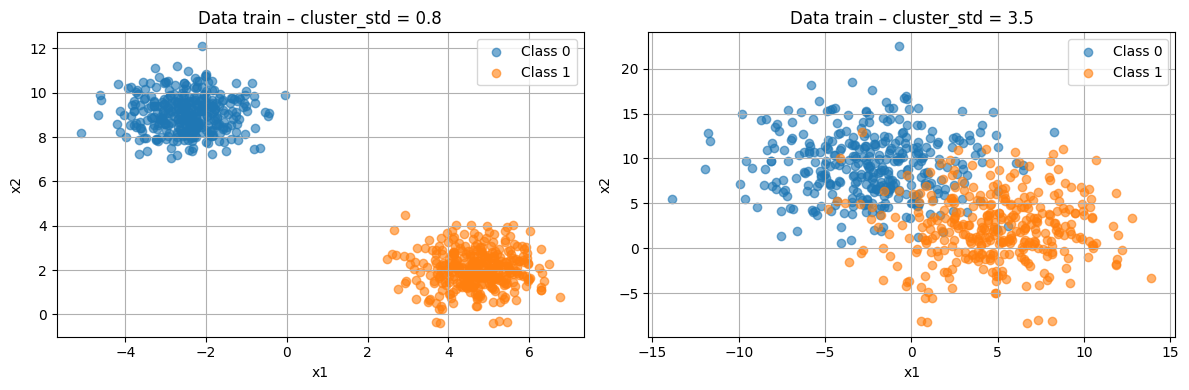

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

for ax, sigma in zip(axes, std_list):
    d = datasets[sigma]
    X_train = d["X_train"]
    y_train_01 = d["y_train_01"]
    
    ax.scatter(X_train[y_train_01 == 0, 0], X_train[y_train_01 == 0, 1],
               alpha=0.6, label="Class 0")
    ax.scatter(X_train[y_train_01 == 1, 0], X_train[y_train_01 == 1, 1],
               alpha=0.6, label="Class 1")
    ax.set_title(f"Data train – cluster_std = {sigma}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()

plt.tight_layout()
plt.show()

### Answers – Exercise 1

1. **Train / test split**  
   Performed with `train_test_split` (70% train, 30% test for each `cluster_std`).

2. **Are the classes linearly separable?**  
   - For `cluster_std = 0.8`: the two clusters are well separated → we can draw a line that almost perfectly separates the classes.  
   - For `cluster_std = 3.5`: the clouds overlap heavily → there is no longer a perfect linear boundary.

3. **Geometric shape of the best linear boundary**  
   In 2D, the linear boundary is a **line** (hyperplane) of the form  
   \[
     w^\top x + b = 0.
   \]  
   Geometrically, it is a line "in the middle" of the two clouds, perpendicular to the line connecting their centers.

4. **Effect of `cluster_std` on separability**  
   - Small `cluster_std` → compact clusters → problem almost linearly separable.  
   - Large `cluster_std` → wide, overlapping clusters → problem not linearly separable, more difficult for linear models.


## Exercise 2 – Perceptron 

Model:

- Prediction: $\hat{y} = \operatorname{sign}(w^\top x + b)$, with $y \in \{-1, +1\}$.
- Update rule for a misclassified point $(x_i, y_i)$:

$$
    w \leftarrow w + \eta (y_i - \hat{y}_i)\, x_i,
    \quad
    b \leftarrow b + \eta (y_i - \hat{y}_i),
$$

where $\eta$ is the learning rate.

Intuition: we move the hyperplane **in the direction of the misclassified point** to put it back on the correct side.


In [ ]:
def perceptron_predict(X, w, b):
    scores = X @ w + b
    return np.where(scores >= 0, 1, -1)


def perceptron_train(X, y, lr=1.0, n_epochs=20):
    n_samples, d = X.shape
    w = np.zeros(d)
    b = 0.0
    errors_per_epoch = []

    for epoch in range(n_epochs):
        n_errors = 0
        for i in range(n_samples):
            x_i = X[i]
            y_i = y[i]
            y_hat = perceptron_predict(x_i.reshape(1, -1), w, b)[0]
            if y_hat != y_i:
                delta = (y_i - y_hat)
                w = w + lr * delta * x_i
                b = b + lr * delta
                n_errors += 1
        errors_per_epoch.append(n_errors)
        print(f"[Perceptron] Epoch {epoch+1}/{n_epochs} - erreurs : {n_errors}")
    return w, b, errors_per_epoch

In [ ]:
# Traing of the perceptron for the 2 std
perc_results = {}

for sigma in std_list:
    print(f"\n=== Perceptron : cluster_std = {sigma} ===")
    d = datasets[sigma]
    w, b, errors = perceptron_train(d["X_train"], d["y_train_pm1"],
                                    lr=1.0, n_epochs=20)
    perc_results[sigma] = dict(w=w, b=b, errors=errors)

    print(f"Final w (sigma={sigma}) =", w)
    print(f"Final b (sigma={sigma}) =", b)


=== Perceptron : cluster_std = 0.8 ===
[Perceptron] Epoch 1/20 - erreurs : 3
[Perceptron] Epoch 2/20 - erreurs : 0
[Perceptron] Epoch 3/20 - erreurs : 0
[Perceptron] Epoch 4/20 - erreurs : 0
[Perceptron] Epoch 5/20 - erreurs : 0
[Perceptron] Epoch 6/20 - erreurs : 0
[Perceptron] Epoch 7/20 - erreurs : 0
[Perceptron] Epoch 8/20 - erreurs : 0
[Perceptron] Epoch 9/20 - erreurs : 0
[Perceptron] Epoch 10/20 - erreurs : 0
[Perceptron] Epoch 11/20 - erreurs : 0
[Perceptron] Epoch 12/20 - erreurs : 0
[Perceptron] Epoch 13/20 - erreurs : 0
[Perceptron] Epoch 14/20 - erreurs : 0
[Perceptron] Epoch 15/20 - erreurs : 0
[Perceptron] Epoch 16/20 - erreurs : 0
[Perceptron] Epoch 17/20 - erreurs : 0
[Perceptron] Epoch 18/20 - erreurs : 0
[Perceptron] Epoch 19/20 - erreurs : 0
[Perceptron] Epoch 20/20 - erreurs : 0
Final w (sigma=0.8) = [17.5079609  -8.79339068]
Final b (sigma=0.8) = 2.0

=== Perceptron : cluster_std = 3.5 ===
[Perceptron] Epoch 1/20 - erreurs : 95
[Perceptron] Epoch 2/20 - erreurs : 

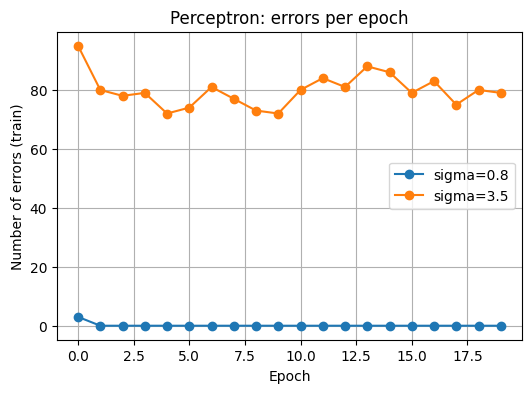

In [30]:
# Curve of the number of errors per epoch for the 2 std
plt.figure()
for sigma in std_list:
    plt.plot(perc_results[sigma]["errors"], marker="o", label=f"sigma={sigma}")
plt.xlabel("Epoch")
plt.ylabel("Number of errors (train)")
plt.title("Perceptron: errors per epoch")
plt.legend()
plt.show()

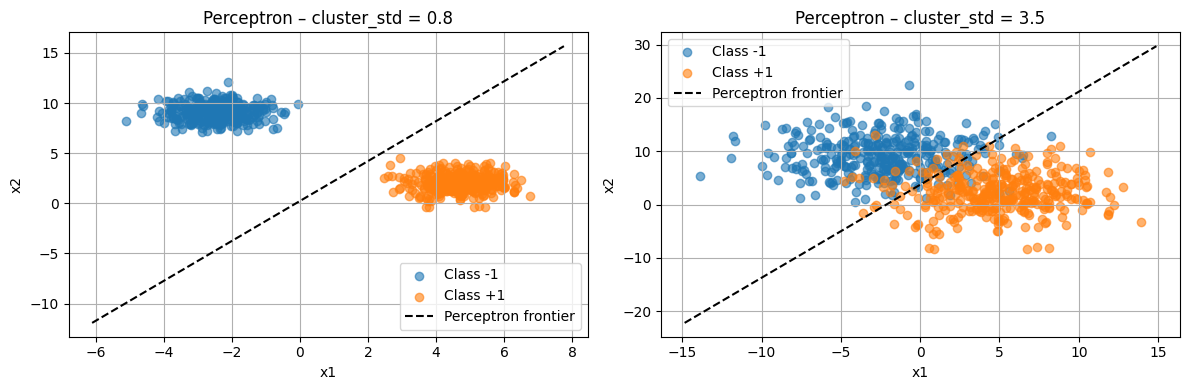

In [31]:
# Frontier of the perceptron for the 2 std
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, sigma in zip(axes, std_list):
    d = datasets[sigma]
    X_train = d["X_train"]
    y_train_pm1 = d["y_train_pm1"]
    w = perc_results[sigma]["w"]
    b = perc_results[sigma]["b"]
    
    # scatter plot
    ax.scatter(X_train[y_train_pm1 == -1, 0], X_train[y_train_pm1 == -1, 1],
               alpha=0.6, label="Class -1")
    ax.scatter(X_train[y_train_pm1 == +1, 0], X_train[y_train_pm1 == +1, 1],
               alpha=0.6, label="Class +1")
    
    # linear frontier: w1 x1 + w2 x2 + b = 0
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x_vals = np.linspace(x1_min, x1_max, 200)
    y_vals = -(w[0] * x_vals + b) / w[1]
    ax.plot(x_vals, y_vals, "k--", label="Perceptron frontier")
    
    ax.set_title(f"Perceptron – cluster_std = {sigma}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()

plt.tight_layout()
plt.show()

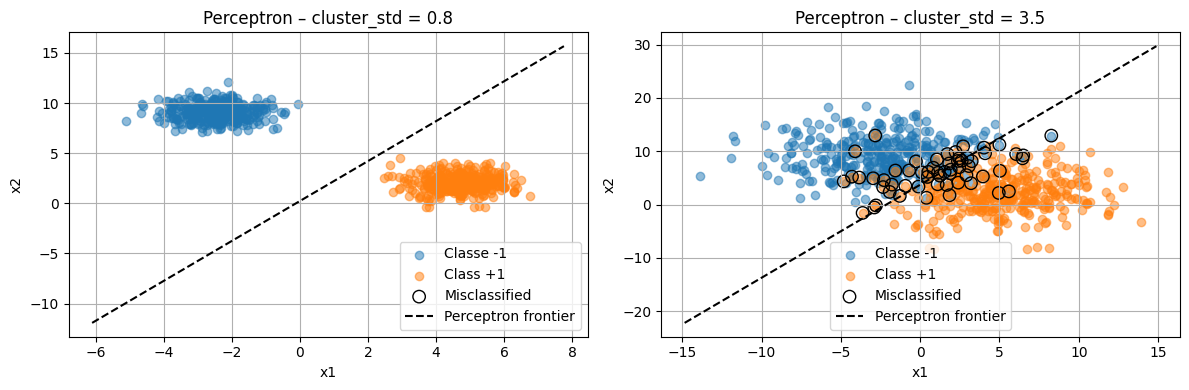

In [34]:
# Plot misclassified points for the 2 std (on the train)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, sigma in zip(axes, std_list):
    d = datasets[sigma]
    X_train = d["X_train"]
    y_train_pm1 = d["y_train_pm1"]
    w = perc_results[sigma]["w"]
    b = perc_results[sigma]["b"]
    
    y_pred_train = perceptron_predict(X_train, w, b)
    mis_idx = np.where(y_pred_train != y_train_pm1)[0]
    
    ax.scatter(X_train[y_train_pm1 == -1, 0], X_train[y_train_pm1 == -1, 1],
               alpha=0.5, label="Classe -1")
    ax.scatter(X_train[y_train_pm1 == +1, 0], X_train[y_train_pm1 == +1, 1],
               alpha=0.5, label="Class +1")
    ax.scatter(X_train[mis_idx, 0], X_train[mis_idx, 1],
               facecolors="none", edgecolors="k", s=80, label="Misclassified")
    
    ax.set_title(f"Misclassified points – sigma = {sigma}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()

    # linear frontier: w1 x1 + w2 x2 + b = 0
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x_vals = np.linspace(x1_min, x1_max, 200)
    y_vals = -(w[0] * x_vals + b) / w[1]
    ax.plot(x_vals, y_vals, "k--", label="Perceptron frontier")
    
    ax.set_title(f"Perceptron – cluster_std = {sigma}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()

plt.tight_layout()
plt.show()

**Comments – Perceptron**

- For `sigma = 0.8`, the number of errors decreases rapidly, and we have few (or even no) misclassified points → the problem is almost linearly separable.  
- For `sigma = 3.5`, the perceptron cannot converge to zero errors (non-separable data) → the boundary oscillates, and many points remain misclassified even after several epochs.


### Answers – Perceptron

1. **When does it converge?**  
   The perceptron converges (i.e., eventually makes no errors) if and only if the data are **linearly separable**.

2. **Geometric interpretation of the update rule**  
   The update rule moves the weight vector \(w\) in the direction of misclassified examples to put them on the correct side of the hyperplane. We "rotate" the hyperplane to correct errors.

3. **Misclassified points**  
   On our data, points close to the boundary or in the overlapping region are often misclassified: they are circled in the figure.


## Exersice 3 - Logistic Regression: 
#### Comparison between σ = 0.8 and σ = 3.5

Logistic model:

$$
p(x) = P(Y=1 \mid X=x) = \sigma(w^\top x + b)
= \frac{1}{1 + e^{-(w^\top x + b)}}.
$$

- **Probabilistic** model: we predict a probability between 0 and 1.  
- Default decision boundary: predict 1 if $p(x) \ge 0.5$ → this is equivalent to $w^\top x + b \ge 0$.

We predict 1 if $p(x) \ge 0.5$. Indeed:

$$
p(x)=\frac{1}{1+e^{-(w^\top x+b)}} \ge 0.5
\iff 1+e^{-(w^\top x+b)} \le 2
\iff e^{-(w^\top x+b)} \le 1
\iff -(w^\top x+b) \le 0
\iff w^\top x+b \ge 0.
$$

Therefore, the 0.5 threshold corresponds exactly to the boundary $w^\top x + b = 0$.

We use scikit-learn's `LogisticRegression`. We now train a logistic regression model for each `cluster_std`.


In [35]:
# Training logistic regression for the 2 std
log_results = {}

for sigma in std_list:
    d = datasets[sigma]
    log_reg = LogisticRegression()
    log_reg.fit(d["X_train"], d["y_train_01"])
    log_results[sigma] = dict(model=log_reg)

log_results

{0.8: {'model': LogisticRegression()}, 3.5: {'model': LogisticRegression()}}

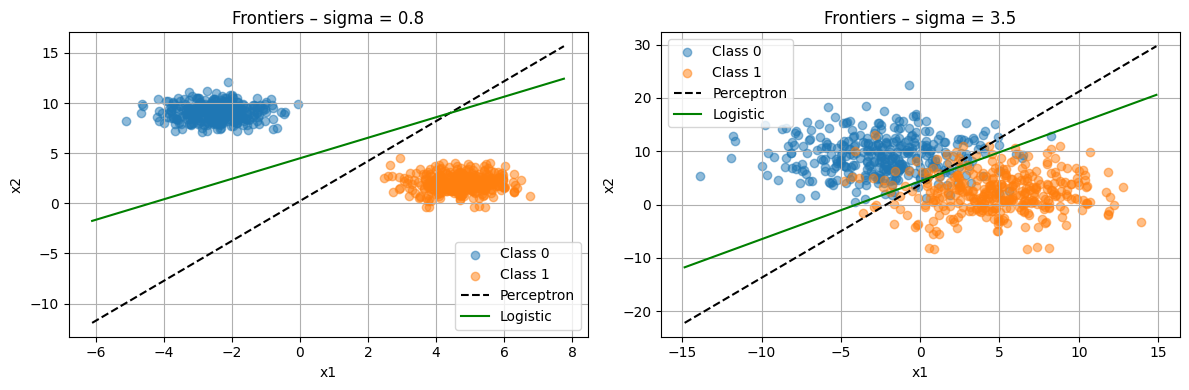

In [36]:
# Frontiers : Perceptron vs Logistic Regression for each std
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, sigma in zip(axes, std_list):
    d = datasets[sigma]
    X_train = d["X_train"]
    y_train_01 = d["y_train_01"]
    w_p = perc_results[sigma]["w"]
    b_p = perc_results[sigma]["b"]
    log_reg = log_results[sigma]["model"]
    w_l = log_reg.coef_[0]
    b_l = log_reg.intercept_[0]
    
    # scatter plot
    ax.scatter(X_train[y_train_01 == 0, 0], X_train[y_train_01 == 0, 1],
               alpha=0.5, label="Class 0")
    ax.scatter(X_train[y_train_01 == 1, 0], X_train[y_train_01 == 1, 1],
               alpha=0.5, label="Class 1")
    
    # perceptron frontier
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x_vals = np.linspace(x1_min, x1_max, 200)
    y_vals_p = -(w_p[0] * x_vals + b_p) / w_p[1]
    ax.plot(x_vals, y_vals_p, "k--", label="Perceptron")
    
    # logistic frontier
    y_vals_l = -(w_l[0] * x_vals + b_l) / w_l[1]
    ax.plot(x_vals, y_vals_l, "g-", label="Logistic")
    
    ax.set_title(f"Frontiers – sigma = {sigma}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()

plt.tight_layout()
plt.show()

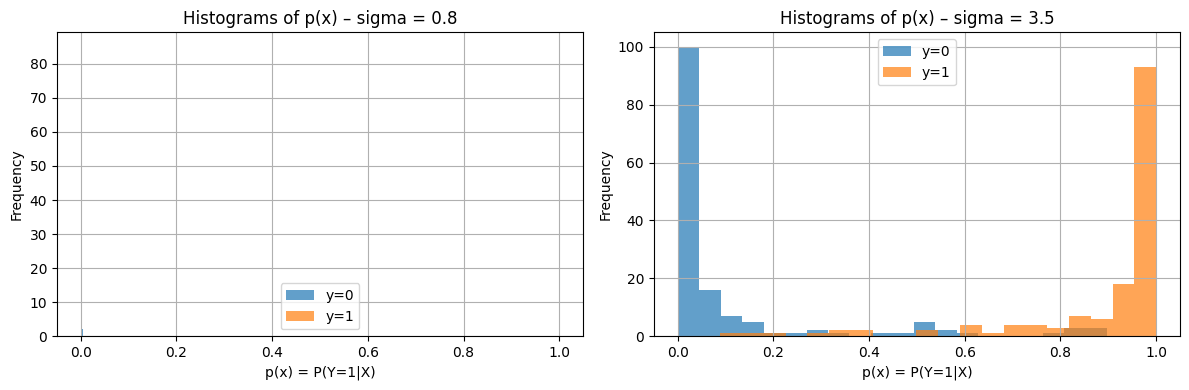

In [37]:
# Histograms of logistic probabilities on the test set for the 2 std
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, sigma in zip(axes, std_list):
    d = datasets[sigma]
    log_reg = log_results[sigma]["model"]
    X_test = d["X_test"]
    y_test_01 = d["y_test_01"]
    
    p_test = log_reg.predict_proba(X_test)[:, 1]
    
    ax.hist(p_test[y_test_01 == 0], bins=20, alpha=0.7, label="y=0")
    ax.hist(p_test[y_test_01 == 1], bins=20, alpha=0.7, label="y=1")
    ax.set_title(f"Histograms of p(x) – sigma = {sigma}")
    ax.set_xlabel("p(x) = P(Y=1|X)")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()

### Theoretical Questions – Logistic Regression

1. **Interpretation of $p(x)$**  
  $p(x)$ is the *estimated* probability (by the model) that the observation belongs to class 1, conditional on $X=x$.

2. **Remarks on the histograms:**

  - For `sigma = 0.8`: the classes are **perfectly separated**.  
    Logistic regression then gives probabilities **exactly 0 or 1**.  
    The histogram therefore appears almost empty: the middle bins are completely empty because all values are concentrated at 0 and 1.  
    The AUC is **strictly equal to 1**, which corresponds to perfect separation.

  - For `sigma = 3.5`: the classes **overlap heavily**.  
    The logistic probabilities become **spread out**, with significant overlap between y=0 and y=1.  
    The AUC is therefore **much lower**, reflecting the difficulty of the problem.


## Exercise 4 - Adding Gaussian Noise

We fix a starting dataset (here the one with `cluster_std = 0.8`) then add Gaussian noise:

$$
X_{\text{noisy}} = X + \varepsilon,\quad \varepsilon \sim \mathcal{N}(0,\sigma^2 I_2)
$$

for $\sigma \in \{0.1, 0.5, 1.0\}$.

For each noise level:
- we retrain a perceptron,
- we retrain a logistic regression,
- we compare the boundaries.

Objective: observe that as noise increases, separability decreases and linear models become more uncertain.


[Perceptron] Epoch 1/15 - erreurs : 3
[Perceptron] Epoch 2/15 - erreurs : 0
[Perceptron] Epoch 3/15 - erreurs : 0
[Perceptron] Epoch 4/15 - erreurs : 0
[Perceptron] Epoch 5/15 - erreurs : 0
[Perceptron] Epoch 6/15 - erreurs : 0
[Perceptron] Epoch 7/15 - erreurs : 0
[Perceptron] Epoch 8/15 - erreurs : 0
[Perceptron] Epoch 9/15 - erreurs : 0
[Perceptron] Epoch 10/15 - erreurs : 0
[Perceptron] Epoch 11/15 - erreurs : 0
[Perceptron] Epoch 12/15 - erreurs : 0
[Perceptron] Epoch 13/15 - erreurs : 0
[Perceptron] Epoch 14/15 - erreurs : 0
[Perceptron] Epoch 15/15 - erreurs : 0
[Perceptron] Epoch 1/15 - erreurs : 3
[Perceptron] Epoch 2/15 - erreurs : 0
[Perceptron] Epoch 3/15 - erreurs : 0
[Perceptron] Epoch 4/15 - erreurs : 0
[Perceptron] Epoch 5/15 - erreurs : 0
[Perceptron] Epoch 6/15 - erreurs : 0
[Perceptron] Epoch 7/15 - erreurs : 0
[Perceptron] Epoch 8/15 - erreurs : 0
[Perceptron] Epoch 9/15 - erreurs : 0
[Perceptron] Epoch 10/15 - erreurs : 0
[Perceptron] Epoch 11/15 - erreurs : 0
[Per

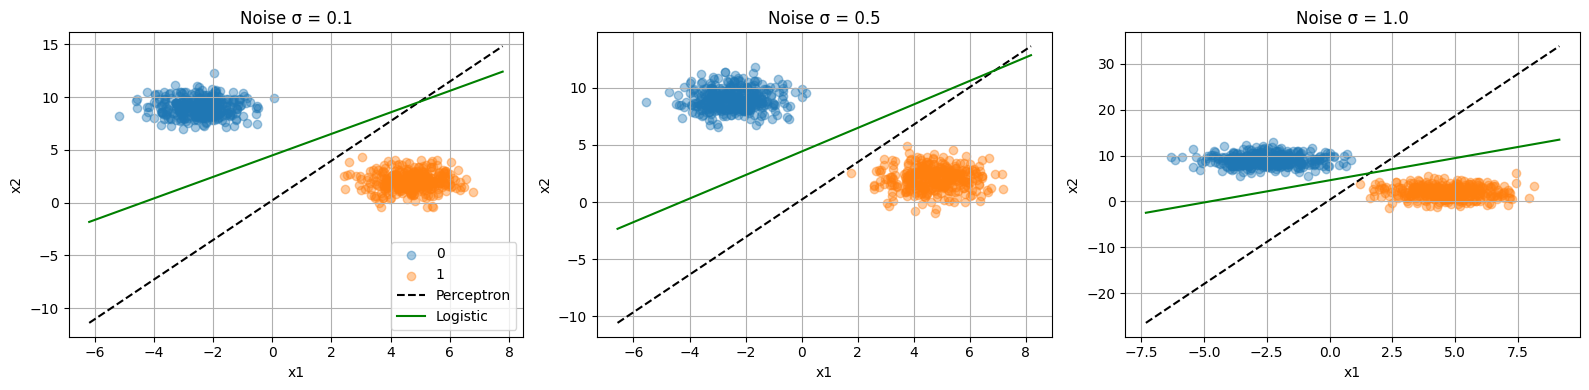

In [38]:
noise_levels = [0.1, 0.5, 1.0]
base_sigma = 0.8  

X_base = datasets[base_sigma]["X"]
y_base_01 = datasets[base_sigma]["y_01"]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, noise_sigma in zip(axes, noise_levels):
    # noise
    eps = np.random.normal(0.0, noise_sigma, size=X_base.shape)
    X_noisy = X_base + eps
    
    # split
    X_tr, X_te, y_tr_01, y_te_01 = train_test_split(
        X_noisy, y_base_01, test_size=0.3, random_state=42, stratify=y_base_01
    )
    y_tr_pm1 = np.where(y_tr_01 == 0, -1, 1)
    
    # perceptron
    w_n, b_n, _ = perceptron_train(X_tr, y_tr_pm1, lr=1.0, n_epochs=15)
    
    # logistic
    log_n = LogisticRegression()
    log_n.fit(X_tr, y_tr_01)
    w_l = log_n.coef_[0]
    b_l = log_n.intercept_[0]
    
    # plot scatter
    ax.scatter(X_tr[y_tr_01 == 0, 0], X_tr[y_tr_01 == 0, 1], alpha=0.4, label="0")
    ax.scatter(X_tr[y_tr_01 == 1, 0], X_tr[y_tr_01 == 1, 1], alpha=0.4, label="1")
    
    # frontiers
    x1_min, x1_max = X_tr[:, 0].min() - 1, X_tr[:, 0].max() + 1
    x_vals = np.linspace(x1_min, x1_max, 200)
    
    # perceptron
    y_vals_p = -(w_n[0] * x_vals + b_n) / w_n[1]
    ax.plot(x_vals, y_vals_p, "k--", label="Perceptron")
    
    # logistic
    y_vals_l = -(w_l[0] * x_vals + b_l) / w_l[1]
    ax.plot(x_vals, y_vals_l, "g-", label="Logistic")
    
    ax.set_title(f"Noise σ = {noise_sigma}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

axes[0].legend()
plt.tight_layout()
plt.show()

As the Gaussian noise increases, the scatters plot become more dispersed and the margin between the classes shrinks.
In this experimental setting, the noise is centered and its amplitude remains smaller than the distance separating the class centers;
as a result, the global structure of the data is preserved and the classes remain linearly separable in the experiments presented.

We observe that:

- the perceptron remains able to find a separating boundary, but this boundary becomes more sensitive to local fluctuations induced by noise;

- logistic regression produces a more stable and smoother boundary, as it optimizes a continuous and probabilistic loss function.

This experiment shows that additive noise degrades the stability and robustness of the models,
without necessarily making the problem non–linearly separable in this setting.
The loss of separability observed in Exercise 3, by contrast, results from a structural overlap of the distributions.

## Exercise 5–6 - Threshold variation, metrics, and ROC

To avoid overloading the figures, we focus here on the case σ = 3.5, which provides a good compromise to illustrate:

the impact of the decision threshold on accuracy, precision, recall, and F1-score;

the ROC curve and the AUC.

In [ ]:
sigma_ref = 3.5
d = datasets[sigma_ref]
log_reg_ref = log_results[sigma_ref]["model"]

X_test = d["X_test"]
y_test_01 = d["y_test_01"]
p_test = log_reg_ref.predict_proba(X_test)[:, 1]

In [47]:
# Change in initiation of threshold
import pandas as pd

thresholds = np.arange(0.1, 1.0, 0.1)
rows = []

for t in thresholds:
    y_pred_t = (p_test >= t).astype(int)
    acc = accuracy_score(y_test_01, y_pred_t)
    prec = precision_score(y_test_01, y_pred_t, zero_division=0)
    rec = recall_score(y_test_01, y_pred_t)
    f1 = f1_score(y_test_01, y_pred_t)
    rows.append([t, acc, prec, rec, f1])

df_thresh = pd.DataFrame(rows, columns=["threshold", "accuracy", "precision", "recall", "f1"])
df_thresh

,threshold,accuracy,precision,recall,f1
0,0.1,0.890000,0.823204,0.993333,0.900302
1,0.2,0.920000,0.875000,0.980000,0.924528
2,0.3,0.926667,0.890244,0.973333,0.929936
3,0.4,0.920000,0.893750,0.953333,0.922581
4,0.5,0.926667,0.910256,0.946667,0.928105
5,0.6,0.940000,0.945946,0.933333,0.939597
6,0.7,0.923333,0.950355,0.893333,0.920962
7,0.8,0.890000,0.946565,0.826667,0.882562
8,0.9,0.870000,1.000000,0.740000,0.850575


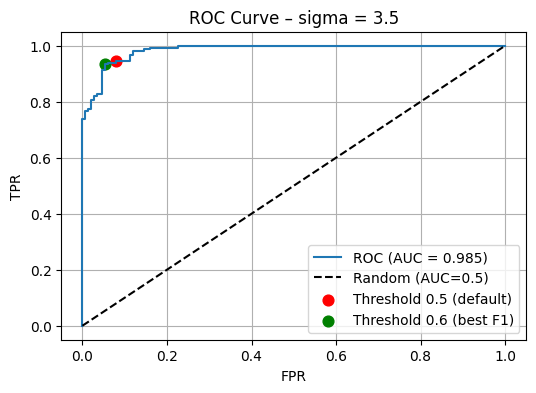

AUC : 0.9850222222222222


In [48]:
# Curve ROC and AUC
fpr, tpr, roc_thr = roc_curve(y_test_01, p_test)
auc = roc_auc_score(y_test_01, p_test)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC=0.5)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"ROC Curve – sigma = {sigma_ref}")
# thresholds to mark
for t, label, color in [(0.5, "Threshold 0.5 (default)", "red"),
                        (0.6, "Threshold 0.6 (best F1)", "green")]:
    idx = np.argmin(np.abs(roc_thr - t))
    plt.scatter(fpr[idx], tpr[idx], color=color, s=60, label=label)
plt.legend()
plt.show()

print(f"AUC : {auc}")

- A **low threshold** favors recall: the majority of positive observations is detected,
    at the cost of a higher number of false positives, which degrades precision.
- A **high threshold** favors precision: positive predictions are more reliable,
    but some positive observations are missed, which reduces recall.

In this case, the analysis of the metrics shows that a threshold of 0.6 offers the best compromise
(maximum precision, recall and F1), while the 0.5 threshold corresponds to the default decision rule.

The ROC curve and the AUC (≈ 0.985) evaluate the discrimination ability of the model independently of the threshold:
they measure the quality of the ranking of observations according to their probability of belonging to the positive class,
and not the performance for a particular threshold.


## Exercise 7 - Loading and Preparing the Real Dataset

We use the `breast_cancer` dataset from scikit-learn.

Steps:

1. Load X, y.  
2. Split train / test (70% / 30%).  
3. Standardize the features with `StandardScaler`.


In [ ]:
data = load_breast_cancer()
X_bc = data.data
y_bc = data.target

X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_bc, y_bc, test_size=0.3, random_state=42, stratify=y_bc
)

scaler = StandardScaler()
X_train_bc_scaled = scaler.fit_transform(X_train_bc)
X_test_bc_scaled = scaler.transform(X_test_bc)

X_train_bc_scaled.shape, X_test_bc_scaled.shape

((398, 30), (171, 30))

## Exercise 8 – Grid Search: Perceptron vs Logistic Regression

We compare:

- Perceptron (with possible regularization),
- Logistic regression (L1 vs L2, different C values),

with cross-validation (5 folds) by maximizing the **AUC ROC**.


In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [43]:
# Grid Search Perceptron
perc = Perceptron()

param_grid_perc = {
    "penalty": [None, "l2", "l1", "elasticnet"],
    "alpha": [1e-4, 1e-3, 1e-2],
    "max_iter": [500, 2000]
}

grid_perc = GridSearchCV(
    perc,
    param_grid=param_grid_perc,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid_perc.fit(X_train_bc_scaled, y_train_bc)

print("Best CV score (Perceptron, AUC) :", grid_perc.best_score_)
print("Best hyperparameters Perceptron :", grid_perc.best_params_)

best_perc = grid_perc.best_estimator_

Best CV score (Perceptron, AUC) : 0.9915540229885057
Best hyperparameters Perceptron : {'alpha': 0.001, 'max_iter': 500, 'penalty': 'elasticnet'}


In [44]:
# Grid Search Logistic Regression
log_clf = LogisticRegression(solver="liblinear")

param_grid_log = {
    "penalty": ["l2", "l1"],
    "C": [0.01, 0.1, 1, 10]
}

grid_log = GridSearchCV(
    log_clf,
    param_grid=param_grid_log,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid_log.fit(X_train_bc_scaled, y_train_bc)

print("Best CV score (Logistic, AUC) :", grid_log.best_score_)
print("Best hyperparameters Logistic :", grid_log.best_params_)

best_log = grid_log.best_estimator_

Best CV score (Logistic, AUC) : 0.9935080459770116
Best hyperparameters Logistic : {'C': 0.01, 'penalty': 'l2'}


In [45]:
# AUC on the test set for the best models
p_test_perc = best_perc.decision_function(X_test_bc_scaled)
p_test_log = best_log.decision_function(X_test_bc_scaled)

auc_perc_test = roc_auc_score(y_test_bc, p_test_perc)
auc_log_test = roc_auc_score(y_test_bc, p_test_log)

print("AUC test – Perceptron :", auc_perc_test)
print("AUC test – Logistic :", auc_log_test)

AUC test – Perceptron : 0.9886098130841121
AUC test – Logistic : 0.9948890186915889


In [46]:
# Visualisation (optional) of logistic regression results as a function of C and penalty
results_log = pd.DataFrame(grid_log.cv_results_)
pivot_log = results_log.pivot_table(
    values="mean_test_score",
    index="param_C",
    columns="param_penalty"
)
pivot_log

param_penalty,l1,l2
param_C,,
0.01,0.980120,0.993508
0.10,0.993407,0.993407
1.00,0.992092,0.993025
10.00,0.987044,0.988234


## Conclusion

On the toy datasets, the impact of the standard deviation `cluster_std` is clear:
with σ = 0.8 (separable in this draw), the perceptron converges quickly and logistic regression produces scores very close to 0 and 1;
with σ = 3.5, the clouds overlap, the perceptron can no longer reach 0 errors and logistic regression provides a more stable but imperfect boundary.

On the real `breast_cancer` dataset, regularized logistic regression generally achieves a higher and more robust AUC than the perceptron, making it a better choice for a medical problem. L2 penalization with a C around 0.1–1 offers a good compromise between bias and variance. A relevant complementary analysis would be to study the coefficients of logistic regression to identify the most discriminant variables and possibly evaluate the calibration of the probabilities (Brier score, reliability plots).
